# CNN Classifier

MDP in Information and Communication Technology, Data Analytics (Tech)

Oona Leppänen

## Imports

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

import sklearn
from statsmodels.stats.contingency_tables import mcnemar

## Set up

### Initialzing Dataset Loading

In [2]:
# A method for loading training and validation sets.
def get_data(file_path, classes, batch_size, max_width, max_height):
  data = keras.utils.image_dataset_from_directory(
      file_path,
      labels = 'inferred',
      label_mode = 'int',
      class_names = classes,
      color_mode = 'rgb',
      batch_size = batch_size,
      image_size = (max_height, max_width),
      shuffle = True,
      pad_to_aspect_ratio = True,
      verbose = True
  )

  return data

In [3]:
# A method for loading test set.
def get_test_data(file_path, classes, batch_size, max_width, max_height):
  data = keras.utils.image_dataset_from_directory(
      file_path,
      labels = 'inferred',
      label_mode = 'int',
      class_names = classes,
      color_mode = 'rgb',
      batch_size = batch_size,
      image_size = (max_height, max_width),
      shuffle = False,
      pad_to_aspect_ratio = True,
      verbose = True
  )

  return data

In [4]:
root_file_path = 'drive/MyDrive/Yliopisto/Diplomityö/Datasets/classification_datasets'
classes = ['human', 'non-human']

In [ ]:
keras.backend.clear_session()

### Function for Printing Example Images

In [ ]:
# Takes one batch of images and their labels
def img_label_example(data):
  for images, labels in data.take(1):
    return images, labels

### Building the CNN Model

The data augmentation layer and the model core are initialized here.

In [ ]:
# Data augmentation initialization
augmentation = Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomBrightness(0.1),
    keras.layers.RandomContrast(0.2),
    keras.layers.RandomSaturation([0.4, 0.6]),
    keras.layers.RandomTranslation(0.1, 0.1)
])

In [ ]:
# Convolution part initialization
def init_conv_model(max_height, max_width):
  model = Sequential()
  model.add(Input(shape=(max_height, max_width, 3)))
  model.add(augmentation)
  model.add(Rescaling(scale = 1./255.))

  model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))
  model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

  model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))
  model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

  model.add(Conv2D(256, (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))
  model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

  model.add(Conv2D(256, (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))
  model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

  return model

In [ ]:
# Fully-connected part initialization
def init_fc_model(model):
  model.add(Flatten())
  model.add(Dense(512, activation = keras.activations.relu))
  model.add(Dense(200, activation = keras.activations.relu))
  model.add(Dense(2))
  model.add(Activation('softmax', dtype = 'float32'))

  return model

Initializing loss and accuracy parameters

In [ ]:
# Initialization of parameters
loss = keras.losses.sparse_categorical_crossentropy
accuracy_metric = keras.metrics.sparse_categorical_accuracy

## Low-Resolution CNN Model

### Loading the Dataset

In [7]:
# The maximum image size in the low-resolution dataset is 340x340.
# Check file 'rescale_images_to_lr.py' for the maximum values.
max_width = 340
max_height = 340
batch_size = 64

print('Training set:')
train_data_lr = get_data(f'{root_file_path}/binary_lr_dataset/train/', classes, batch_size, max_width, max_height)

print('\nValidation set:')
valid_data_lr = get_data(f'{root_file_path}/binary_lr_dataset/validation/', classes, batch_size, max_width, max_height)

print('\nTest set:')
test_data_lr = get_test_data(f'{root_file_path}/binary_lr_dataset/test/', classes, batch_size, max_width, max_height)

Training set:
Found 2664 files belonging to 2 classes.

Validation set:
Found 332 files belonging to 2 classes.

Test set:
Found 331 files belonging to 2 classes.


#### Example Images

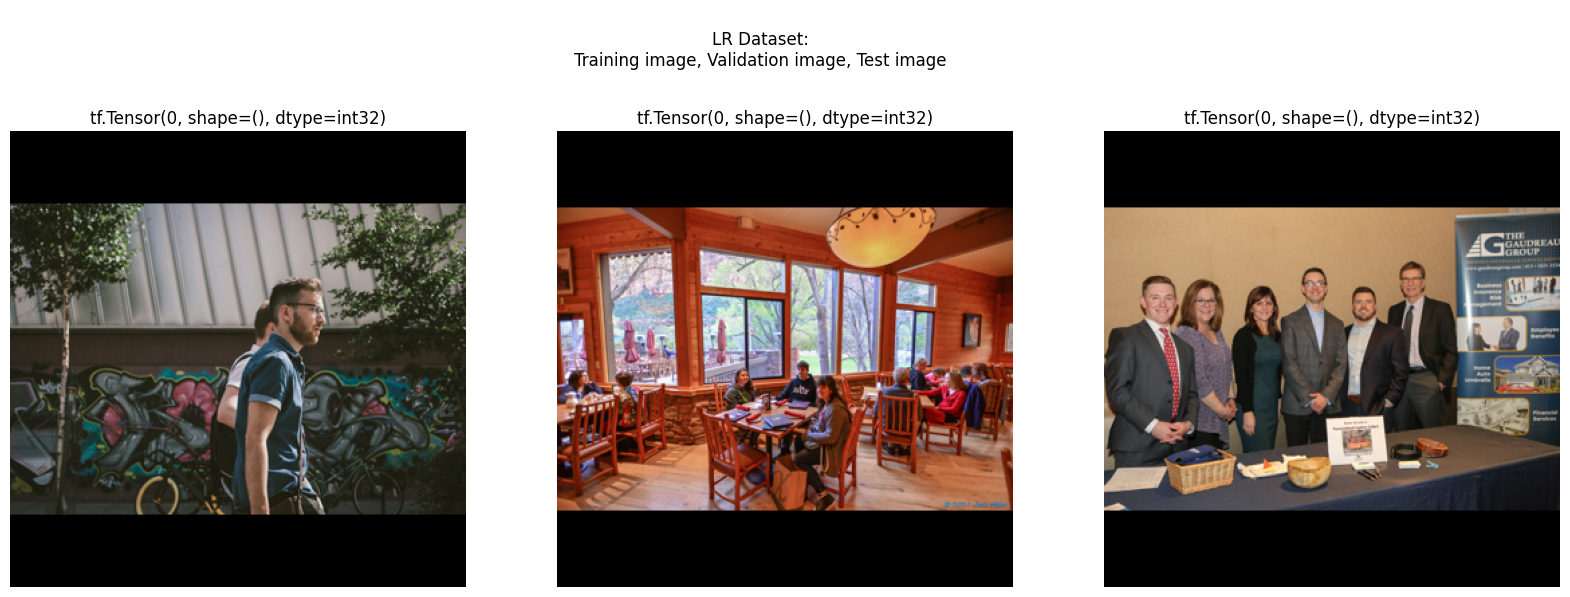

In [ ]:
# Printing one example image per set per dataset.
plt.figure(figsize = (20, 20))
plt.suptitle(f'\nLR Dataset:\nTraining image, Validation image, Test image', y = 0.67)

train_image, train_label = img_label_example(train_data_lr)
valid_image, valid_label = img_label_example(valid_data_lr)
test_image, test_label = img_label_example(test_data_lr)

for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.axis('off')

  if i == 0:
    plt.title(train_label[0])
    plt.imshow(train_image[0].numpy().astype('uint8'))

  elif i == 1:
    plt.title(valid_label[0])
    plt.imshow(valid_image[0].numpy().astype('uint8'))

  elif i == 2:
    plt.title(test_label[0])
    plt.imshow(test_image[0].numpy().astype('uint8'))

plt.show()

### Training the CNN Model



In [ ]:
# Initializing optimizer parameter
optimizer = keras.optimizers.RMSprop()

# Initializing a CNN model and compiling it
lr_model = init_conv_model(max_height, max_width)
lr_model = init_fc_model(lr_model)

lr_model.summary()
lr_model.compile(loss = loss, optimizer = optimizer, metrics = [accuracy_metric])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 340, 340, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 340, 340, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 340, 340, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 170, 170, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 170, 170, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 85, 85, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 43, 43, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 43, 43, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 3, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │       102,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           402 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,806,234 (6.89 MB)

 Trainable params: 1,806,234 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Initializing the best model save using model checkpoint call.
lr_checkpoint_file_path = 'drive/MyDrive/Yliopisto/Diplomityö/Code/CNN_classifier/checkpoint.lr_best_model.keras'
lr_model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = lr_checkpoint_file_path,
    monitor = '',
    mode = 'max',
    save_best_only = True
)

# Training the CNN model.
lr_history = lr_model.fit(
    train_data_lr,
    batch_size = batch_size,
    epochs = 120,
    verbose = 2,
    callbacks = [lr_model_checkpoint],
    validation_data = valid_data_lr
)

Epoch 1/120


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with  available.
  if self._should_save_model(epoch, batch, logs, filepath):


42/42 - 109s - 3s/step - loss: 0.6679 - sparse_categorical_accuracy: 0.7035 - val_loss: 0.6132 - val_sparse_categorical_accuracy: 0.7018
Epoch 2/120
42/42 - 10s - 250ms/step - loss: 0.6103 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.6119 - val_sparse_categorical_accuracy: 0.7018
Epoch 3/120
42/42 - 10s - 250ms/step - loss: 0.6118 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.6094 - val_sparse_categorical_accuracy: 0.7018
Epoch 4/120
42/42 - 11s - 255ms/step - loss: 0.6105 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.6112 - val_sparse_categorical_accuracy: 0.7018
Epoch 5/120
42/42 - 11s - 258ms/step - loss: 0.6102 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.6108 - val_sparse_categorical_accuracy: 0.7018
Epoch 6/120
42/42 - 11s - 256ms/step - loss: 0.6096 - sparse_categorical_accuracy: 0.6997 - val_loss: 0.6112 - val_sparse_categorical_accuracy: 0.7018
Epoch 7/120
42/42 - 11s - 257ms/step - loss: 0.6092 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.6052

### Evaluation and Performance of the CNN Model

#### Loss and Accuracy

In [ ]:
# Saving history data into memory for future usage.
lr_history_params = lr_history.params
lr_history_data = lr_history.history
print(lr_history_params)
print(lr_history_data)

{'verbose': 2, 'epochs': 120, 'steps': 42}
{'loss': [0.6679204106330872, 0.6103132367134094, 0.6117861270904541, 0.6104808449745178, 0.6101734042167664, 0.6096262335777283, 0.6091952919960022, 0.5706648230552673, 0.5492051243782043, 0.531211256980896, 0.5383302569389343, 0.5190076231956482, 0.5117684006690979, 0.5077984929084778, 0.5104613304138184, 0.5006980299949646, 0.4987468421459198, 0.5012491941452026, 0.49257010221481323, 0.48587512969970703, 0.48387259244918823, 0.4846106767654419, 0.4825514256954193, 0.4969427287578583, 0.4779036343097687, 0.4766610562801361, 0.4754434823989868, 0.4658863842487335, 0.46184876561164856, 0.48180657625198364, 0.46309223771095276, 0.4667879045009613, 0.4532845914363861, 0.46711885929107666, 0.4487582743167877, 0.45682835578918457, 0.4521542191505432, 0.4459660053253174, 0.44811809062957764, 0.4333012104034424, 0.4305354058742523, 0.44294148683547974, 0.4320610463619232, 0.43465855717658997, 0.42680102586746216, 0.4232703745365143, 0.42476055026054

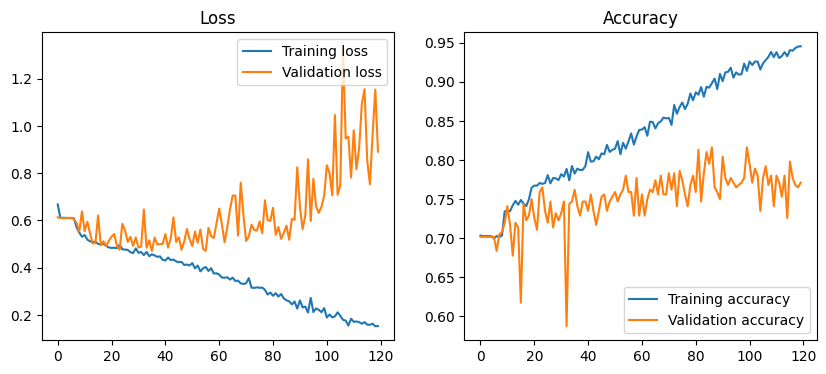

In [ ]:
plt.figure(figsize = (10, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(lr_history_data['loss'], label = 'Training loss')
plt.plot(lr_history_data['val_loss'], label = 'Validation loss')
plt.title('Loss')
plt.legend(loc = 'upper right')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(lr_history_data['sparse_categorical_accuracy'], label = 'Training accuracy')
plt.plot(lr_history_data['val_sparse_categorical_accuracy'], label = 'Validation accuracy')
plt.title('Accuracy')
plt.legend(loc = 'lower right')

plt.show()

#### Evaluation of the CNN Model

In [ ]:
lr_checkpoint_file_path = 'drive/MyDrive/Yliopisto/Diplomityö/Code/CNN_classifier/checkpoint.lr_best_model.keras'
best_lr_model = keras.models.load_model(lr_checkpoint_file_path)
best_lr_evaluation = best_lr_model.evaluate(test_data_lr, verbose = 2)

6/6 - 18s - 3s/step - loss: 1.0643 - sparse_categorical_accuracy: 0.8036


#### Prediction and Performance Metrics

In [8]:
# Prediction
lr_predictions = best_lr_model.predict(test_data_lr )
lr_predictions = np.argmax(lr_predictions, axis = 1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


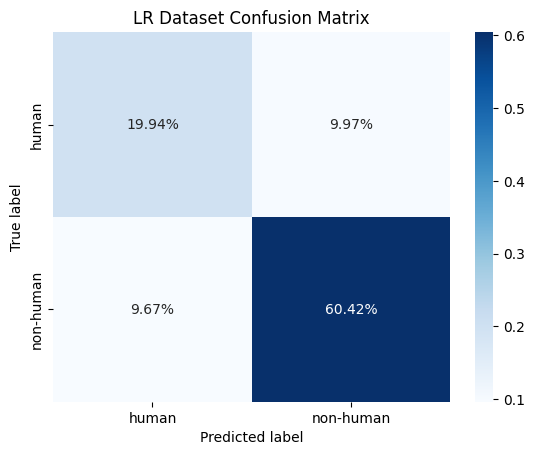

In [ ]:
# Confusion Matrix

lr_labels = np.concatenate([label for image, label in test_data_lr], axis=0)

lr_con_matrix = sklearn.metrics.confusion_matrix(lr_labels, lr_predictions)
sns.heatmap(lr_con_matrix/np.sum(lr_con_matrix), annot=True, xticklabels=classes,
            yticklabels=classes, fmt='.2%', cmap='Blues')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('LR Dataset Confusion Matrix')
plt.savefig('drive/MyDrive/Yliopisto/Diplomityö/Kuvat/lr_confusion_matrix.png')
plt.show()

In [ ]:
# Precision, Recall and F1-score

metric_values = sklearn.metrics.precision_recall_fscore_support(lr_labels, lr_predictions, average='macro')

lr_precision = metric_values[0]
lr_recall = metric_values[1]
lr_f1_score = metric_values[2]

print('precision: ', lr_precision)
print('recall:    ', lr_recall)
print('F1 score:  ', lr_f1_score)

precision:  0.7659192432337742
recall:     0.764367816091954
F1 score:   0.7651329075923803


## High-Resolution CNN Model

In [ ]:
# Clearing the previous session and using Mixed precision
keras.backend.clear_session()
keras.config.set_dtype_policy("mixed_float16")

### Loading the Dataset

In [9]:
# The maximum image size in the high-resolution dataset is 2040x2040.
# For ensuring better comparability the 1360x1360 size is used.
max_width = 1360
max_height = 1360
batch_size = 18

print('Training set:')
train_data_hr = get_data(f'{root_file_path}/binary_hr_dataset/train/', classes, batch_size, max_width, max_height)

print('\nValidation set:')
valid_data_hr = get_data(f'{root_file_path}/binary_hr_dataset/validation/', classes, batch_size, max_width, max_height)

print('\nTest set:')
test_data_hr = get_test_data(f'{root_file_path}/binary_hr_dataset/test/', classes, batch_size, max_width, max_height)

Training set:
Found 2664 files belonging to 2 classes.

Validation set:
Found 332 files belonging to 2 classes.

Test set:
Found 331 files belonging to 2 classes.


#### Example Images

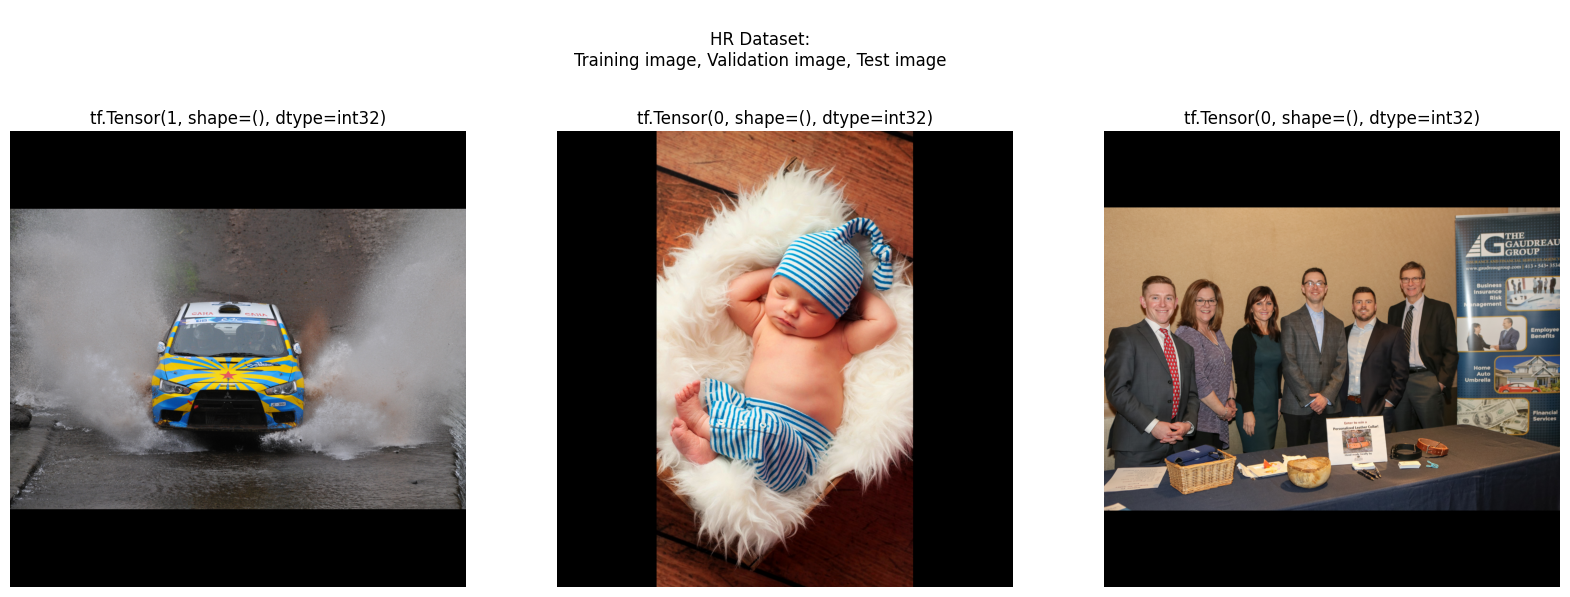

In [ ]:
# Printing one example image per set per dataset.
plt.figure(figsize = (20, 20))
plt.suptitle(f'\nHR Dataset:\nTraining image, Validation image, Test image', y = 0.67)

train_image, train_label = img_label_example(train_data_hr)
valid_image, valid_label = img_label_example(valid_data_hr)
test_image, test_label = img_label_example(test_data_hr)

for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.axis('off')

  if i == 0:
    plt.title(train_label[0])
    plt.imshow(train_image[0].numpy().astype('uint8'))

  elif i == 1:
    plt.title(valid_label[0])
    plt.imshow(valid_image[0].numpy().astype('uint8'))

  elif i == 2:
    plt.title(test_label[0])
    plt.imshow(test_image[0].numpy().astype('uint8'))

plt.show()

### Training the CNN Model

In [ ]:
# Initializing optimizer parameter
optimizer = keras.optimizers.RMSprop(learning_rate = 0.0001)

# Initializing a CNN model and compiling it
hr_model = init_conv_model(max_height, max_width)
hr_model.add(Conv2D(256, (3, 3), padding = 'same', activation = 'relu'))
hr_model.add(MaxPooling2D(pool_size = (2, 2),  strides = 2,padding = 'same'))
hr_model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
hr_model.add(MaxPooling2D(pool_size = (2, 2),  strides = 2,padding = 'same'))
hr_model = init_fc_model(hr_model)

hr_model.summary()
hr_model.compile(loss = loss, optimizer = optimizer, metrics = [accuracy_metric])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 1360, 1360, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 1360, 1360, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 1360, 1360, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 680, 680, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 680, 680, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 340, 340, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 340, 340, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 170, 170, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 170, 170, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 85, 85, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 85, 85, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 43, 43, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 3, 3, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │       102,60

 Total params: 2,396,442 (9.14 MB)

 Trainable params: 2,396,442 (9.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Initializing the best model save using model checkpoint call.
hr_checkpoint_file_path = 'drive/MyDrive/Yliopisto/Diplomityö/Code/CNN_classifier/checkpoint.hr_best_model.keras'
hr_model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = hr_checkpoint_file_path,
    monitor = '',
    mode = 'max',
    save_best_only = True
)

# Training the CNN model.
history = hr_model.fit(
    train_data_hr,
    batch_size = batch_size,
    epochs = 120,
    verbose = 2,
    callbacks = [hr_model_checkpoint],
    validation_data = valid_data_hr
)

Epoch 1/120


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with  available.
  if self._should_save_model(epoch, batch, logs, filepath):


148/148 - 313s - 2s/step - loss: 0.6305 - sparse_categorical_accuracy: 0.6989 - val_loss: 0.6134 - val_sparse_categorical_accuracy: 0.7018
Epoch 2/120
148/148 - 130s - 880ms/step - loss: 0.6139 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.6103 - val_sparse_categorical_accuracy: 0.7018
Epoch 3/120
148/148 - 131s - 882ms/step - loss: 0.6130 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.6031 - val_sparse_categorical_accuracy: 0.7018
Epoch 4/120
148/148 - 131s - 885ms/step - loss: 0.5961 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.6071 - val_sparse_categorical_accuracy: 0.7018
Epoch 5/120
148/148 - 131s - 886ms/step - loss: 0.5881 - sparse_categorical_accuracy: 0.7035 - val_loss: 0.6119 - val_sparse_categorical_accuracy: 0.7018
Epoch 6/120
148/148 - 132s - 895ms/step - loss: 0.5724 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.6139 - val_sparse_categorical_accuracy: 0.7108
Epoch 7/120
148/148 - 131s - 885ms/step - loss: 0.5530 - sparse_categorical_accuracy: 0.722

### Evaluation and Performance of the CNN Model

#### Loss and Accuracy

In [ ]:
# Saving history data into memory for future usage.
hr_history_params = history.params
hr_history_data = history.history
print(hr_history_params)
print(hr_history_data)

{'verbose': 2, 'epochs': 120, 'steps': 148}
{'loss': [0.6305017471313477, 0.6138627529144287, 0.6129873394966125, 0.5960562825202942, 0.58805912733078, 0.5723649859428406, 0.5529649257659912, 0.5474837422370911, 0.5425884127616882, 0.5339105725288391, 0.5274718403816223, 0.5254184007644653, 0.5222769975662231, 0.5175953507423401, 0.5203008055686951, 0.514013946056366, 0.5011343359947205, 0.49689623713493347, 0.4881799817085266, 0.4900326132774353, 0.4833308458328247, 0.4760633707046509, 0.46291065216064453, 0.46388593316078186, 0.4541597068309784, 0.4548467695713043, 0.44691604375839233, 0.439179390668869, 0.43589332699775696, 0.433605432510376, 0.42699170112609863, 0.417807400226593, 0.4202197790145874, 0.4064044654369354, 0.41056525707244873, 0.40569716691970825, 0.39879605174064636, 0.39378729462623596, 0.3876824676990509, 0.3849470317363739, 0.38597652316093445, 0.3927502930164337, 0.38378241658210754, 0.36455094814300537, 0.3637045919895172, 0.3537711203098297, 0.3452124297618866,

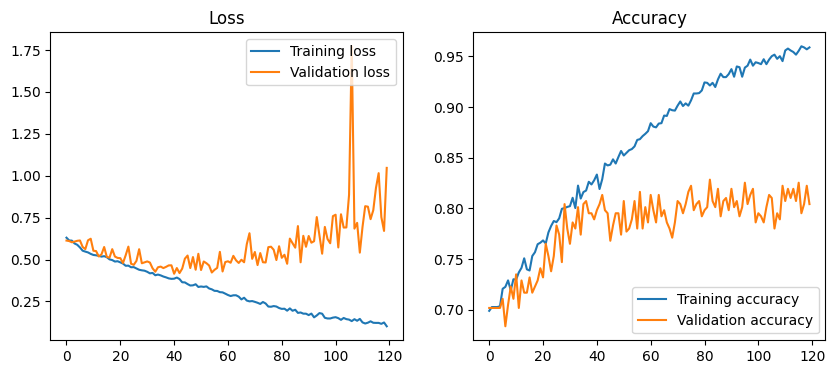

In [ ]:
plt.figure(figsize = (10, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(hr_history_data['loss'], label = 'Training loss')
plt.plot(hr_history_data['val_loss'], label = 'Validation loss')
plt.title('Loss')
plt.legend(loc = 'upper right')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(hr_history_data['sparse_categorical_accuracy'], label = 'Training accuracy')
plt.plot(hr_history_data['val_sparse_categorical_accuracy'], label = 'Validation accuracy')
plt.title('Accuracy')
plt.legend(loc = 'lower right')

plt.show()

#### Evaluation of the CNN Model

In [ ]:
hr_checkpoint_file_path = 'drive/MyDrive/Yliopisto/Diplomityö/Code/CNN_classifier/checkpoint.hr_best_model.keras'
best_hr_model = keras.models.load_model(hr_checkpoint_file_path)
best_hr_evaluation = best_hr_model.evaluate(test_data_hr, verbose = 2)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


19/19 - 35s - 2s/step - loss: 1.2627 - sparse_categorical_accuracy: 0.7795


#### Prediction and Performance Metrics

In [11]:
# Prediction
hr_predictions = best_hr_model.predict(test_data_hr)
hr_predictions = np.argmax(hr_predictions, axis = 1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step


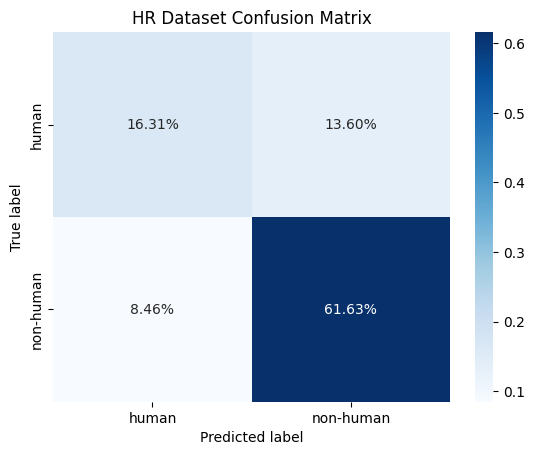

In [ ]:
# Confusion Matrix

hr_labels = np.concatenate([label for image, label in test_data_hr], axis=0)

hr_con_matrix = sklearn.metrics.confusion_matrix(hr_labels, hr_predictions)
sns.heatmap(hr_con_matrix/np.sum(hr_con_matrix), annot=True, xticklabels=classes,
            yticklabels=classes, fmt='.2%', cmap='Blues')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('HR Dataset Confusion Matrix')
plt.savefig('drive/MyDrive/Yliopisto/Diplomityö/Kuvat/hr_confusion_matrix.png')
plt.show()

In [ ]:
# Precision, Recall and F1-score

metric_values = sklearn.metrics.precision_recall_fscore_support(hr_labels, hr_predictions, average='macro')

hr_precision = metric_values[0]
hr_recall = metric_values[1]
hr_f1_score = metric_values[2]

print('precision: ', hr_precision)
print('recall:    ', hr_recall)
print('F1 score:  ', hr_f1_score)

precision:  0.7389068468997944
recall:     0.7123824451410659
F1 score:   0.7224589655528882


## Super-resolution CNN Model

In [ ]:
# Clearing the previous session and using Mixed precision
keras.backend.clear_session()
keras.config.set_dtype_policy("mixed_float16")

### Loading the Dataset

In [12]:
# The maximum image size in the low-resolution dataset is 1360x1360.
max_width = 1360
max_height = 1360
batch_size = 18

print('Training set:')
train_data_sr = get_data(f'{root_file_path}/binary_sr_dataset/train/', classes, batch_size, max_width, max_height)

print('\nValidation set:')
valid_data_sr = get_data(f'{root_file_path}/binary_sr_dataset/validation/', classes, batch_size, max_width, max_height)

print('\nTest set:')
test_data_sr = get_test_data(f'{root_file_path}/binary_sr_dataset/test/', classes, batch_size, max_width, max_height)

Training set:
Found 2664 files belonging to 2 classes.

Validation set:
Found 332 files belonging to 2 classes.

Test set:
Found 331 files belonging to 2 classes.


#### Example images

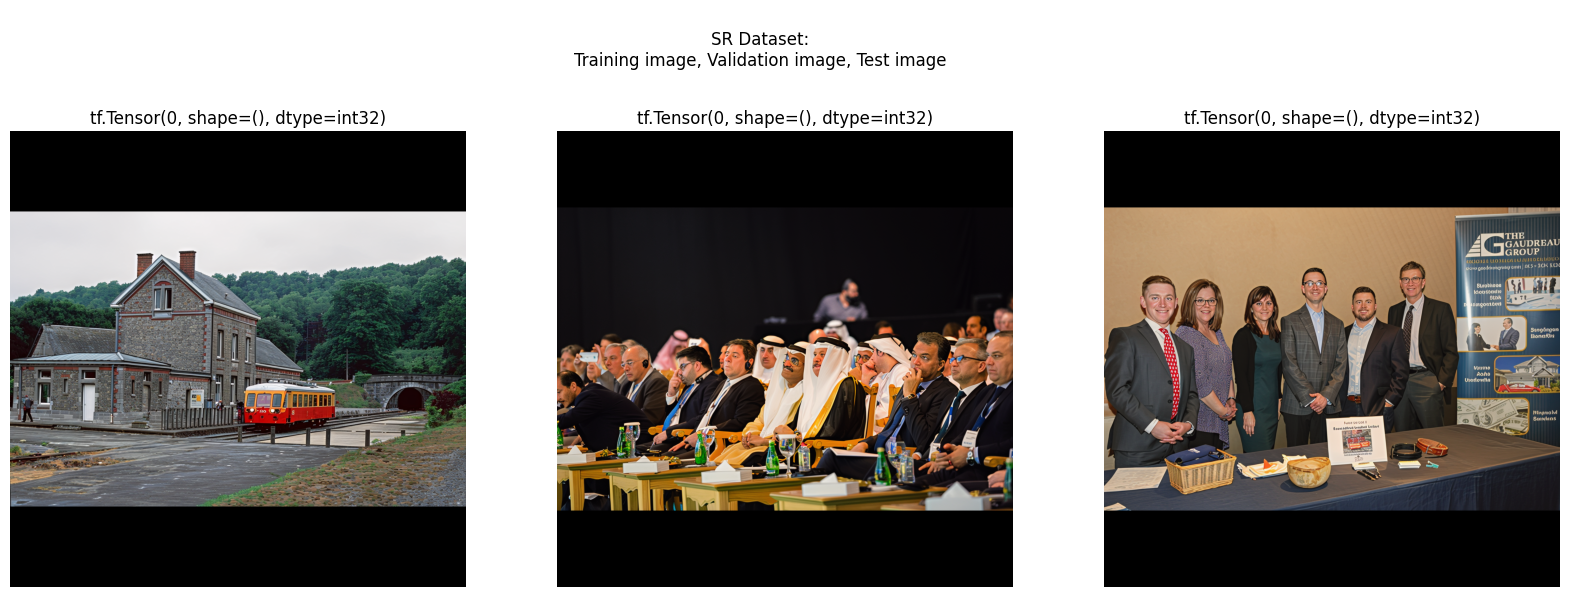

In [ ]:
# Printing one example image per set per dataset.
plt.figure(figsize = (20, 20))
plt.suptitle(f'\nSR Dataset:\nTraining image, Validation image, Test image', y = 0.67)

train_image, train_label = img_label_example(train_data_sr)
valid_image, valid_label = img_label_example(valid_data_sr)
test_image, test_label = img_label_example(test_data_sr)

for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.axis('off')

  if i == 0:
    plt.title(train_label[0])
    plt.imshow(train_image[0].numpy().astype('uint8'))

  elif i == 1:
    plt.title(valid_label[0])
    plt.imshow(valid_image[0].numpy().astype('uint8'))

  elif i == 2:
    plt.title(test_label[0])
    plt.imshow(test_image[0].numpy().astype('uint8'))

plt.show()

### Training the CNN Model

In [ ]:
# Initializing optimizer parameter
optimizer = keras.optimizers.RMSprop(learning_rate = 0.0001)

# Initializing a CNN model and compiling it
model = init_conv_model(max_height, max_width)
model.add(Conv2D(256, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2),  strides = 2,padding = 'same'))
model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2),  strides = 2,padding = 'same'))
model = init_fc_model(model)

model.summary()
model.compile(loss = loss, optimizer = optimizer, metrics = [accuracy_metric])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 1360, 1360, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 1360, 1360, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 1360, 1360, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 680, 680, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 680, 680, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 340, 340, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 340, 340, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 170, 170, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 170, 170, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 85, 85, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 85, 85, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 43, 43, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 3, 3, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │       102,60

 Total params: 2,396,442 (9.14 MB)

 Trainable params: 2,396,442 (9.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Initializing the best model save using model checkpoint call.
sr_checkpoint_file_path = 'drive/MyDrive/Yliopisto/Diplomityö/Code/CNN_classifier/checkpoint.diffusion_best_model.keras'
sr_model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = sr_checkpoint_file_path,
    monitor = '',
    mode = 'max',
    save_best_only = True
)

# Training the CNN model.
sr_history = model.fit(
    train_data_sr,
    batch_size = batch_size,
    epochs = 120,
    verbose = 2,
    callbacks = [sr_model_checkpoint],
    validation_data = valid_data_sr
)

Epoch 1/120


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with  available.
  if self._should_save_model(epoch, batch, logs, filepath):


148/148 - 308s - 2s/step - loss: 0.6255 - sparse_categorical_accuracy: 0.7023 - val_loss: 0.6094 - val_sparse_categorical_accuracy: 0.7018
Epoch 2/120
148/148 - 130s - 879ms/step - loss: 0.6094 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.6142 - val_sparse_categorical_accuracy: 0.7018
Epoch 3/120
148/148 - 130s - 881ms/step - loss: 0.5990 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.6054 - val_sparse_categorical_accuracy: 0.7018
Epoch 4/120
148/148 - 130s - 878ms/step - loss: 0.5801 - sparse_categorical_accuracy: 0.7110 - val_loss: 0.5872 - val_sparse_categorical_accuracy: 0.7169
Epoch 5/120
148/148 - 129s - 875ms/step - loss: 0.5511 - sparse_categorical_accuracy: 0.7233 - val_loss: 0.5963 - val_sparse_categorical_accuracy: 0.7229
Epoch 6/120
148/148 - 129s - 873ms/step - loss: 0.5547 - sparse_categorical_accuracy: 0.7162 - val_loss: 0.5596 - val_sparse_categorical_accuracy: 0.7108
Epoch 7/120
148/148 - 129s - 873ms/step - loss: 0.5396 - sparse_categorical_accuracy: 0.727

### Evaluation and Performance of the CNN model

#### Loss and Accuracy

In [ ]:
# Saving history data into memory for future usage.
sr_history_params = sr_history.params
sr_history_data = sr_history.history
print(sr_history_params)
print(sr_history_data)

{'verbose': 2, 'epochs': 120, 'steps': 148}
{'loss': [0.6254855394363403, 0.6093533039093018, 0.5989621877670288, 0.5801278948783875, 0.5510656833648682, 0.5547288060188293, 0.5396307706832886, 0.5316497087478638, 0.5308182835578918, 0.5217410922050476, 0.5175560116767883, 0.5149241089820862, 0.5018527507781982, 0.4962109625339508, 0.4859074652194977, 0.4770779609680176, 0.46529290080070496, 0.4702508747577667, 0.4622371196746826, 0.45479816198349, 0.4463983476161957, 0.4522578716278076, 0.44734910130500793, 0.44170939922332764, 0.43709808588027954, 0.43721410632133484, 0.433114230632782, 0.4267515242099762, 0.432500422000885, 0.42897066473960876, 0.42659199237823486, 0.41453754901885986, 0.4115544259548187, 0.41592034697532654, 0.40667128562927246, 0.4052353501319885, 0.4019296169281006, 0.4059128761291504, 0.40180253982543945, 0.3932299017906189, 0.39534565806388855, 0.39676135778427124, 0.39464226365089417, 0.3893716633319855, 0.3787297308444977, 0.38660895824432373, 0.3778525590896

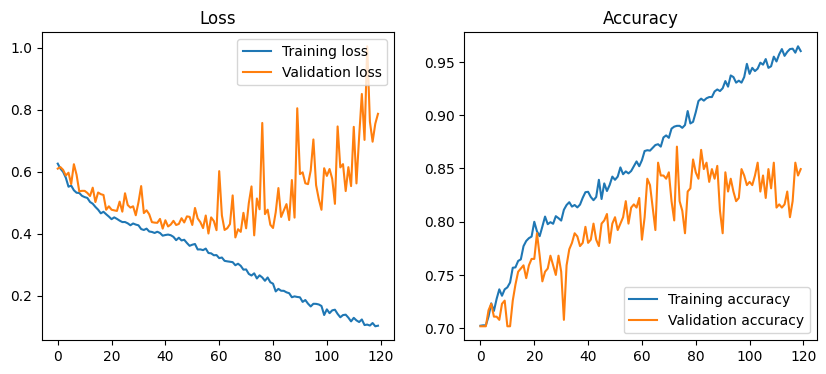

In [ ]:
plt.figure(figsize = (10, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(sr_history_data['loss'], label = 'Training loss')
plt.plot(sr_history_data['val_loss'], label = 'Validation loss')
plt.title('Loss')
plt.legend(loc = 'upper right')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(sr_history_data['sparse_categorical_accuracy'], label = 'Training accuracy')
plt.plot(sr_history_data['val_sparse_categorical_accuracy'], label = 'Validation accuracy')
plt.title('Accuracy')
plt.legend(loc = 'lower right')

plt.show()

#### Evaluation of the CNN model

In [ ]:
sr_checkpoint_file_path = 'drive/MyDrive/Yliopisto/Diplomityö/Code/CNN_classifier/checkpoint.diffusion_best_model.keras'
best_sr_model = keras.models.load_model(sr_checkpoint_file_path)
best_sr_evaluation = best_sr_model.evaluate(test_data_sr, verbose = 2)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


19/19 - 34s - 2s/step - loss: 0.7157 - sparse_categorical_accuracy: 0.8248


#### Prediction and Performance Metrics

In [14]:
# Prediction
sr_predictions = best_sr_model.predict(test_data_sr)
sr_predictions = np.argmax(sr_predictions, axis = 1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step


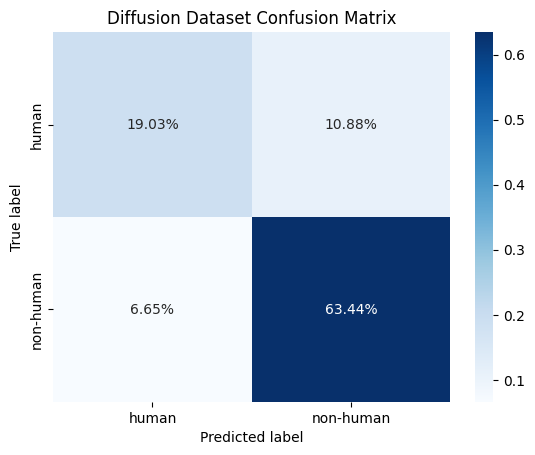

In [ ]:
# Confusion Matrix

sr_labels = np.concatenate([label for image, label in test_data_sr], axis=0)

sr_con_matrix = sklearn.metrics.confusion_matrix(sr_labels, sr_predictions)
sns.heatmap(sr_con_matrix/np.sum(sr_con_matrix), annot=True, xticklabels=classes,
            yticklabels=classes, fmt='.2%', cmap='Blues')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Diffusion Dataset Confusion Matrix')
plt.savefig('drive/MyDrive/Yliopisto/Diplomityö/Kuvat/sr_confusion_matrix.png')
plt.show()

In [ ]:
# Precision, Recall and F1-score

metric_values = sklearn.metrics.precision_recall_fscore_support(sr_labels, sr_predictions, average='macro')

sr_precision = metric_values[0]
sr_recall = metric_values[1]
sr_f1_score = metric_values[2]

print('precision: ', sr_precision)
print('recall:    ', sr_recall)
print('F1 score:  ', sr_f1_score)

precision:  0.7974175035868005
recall:     0.77076802507837
F1 score:   0.7817218482808805


## McNemar's Test

In [23]:
lr_labels = np.concatenate([label for image, label in test_data_lr], axis=0)
hr_labels = np.concatenate([label for image, label in test_data_hr], axis=0)
sr_labels = np.concatenate([label for image, label in test_data_sr], axis=0)

lr_classifier = [1 if prediction == ground_truth else 0 for prediction, ground_truth in zip(lr_predictions, lr_labels)]
hr_classifier = [1 if prediction == ground_truth else 0 for prediction, ground_truth in zip(hr_predictions, hr_labels)]
sr_classifier = [1 if prediction == ground_truth else 0 for prediction, ground_truth in zip(sr_predictions, sr_labels)]

i = 0

for classifiers in ([lr_classifier, hr_classifier], [lr_classifier, sr_classifier], [hr_classifier, sr_classifier]):
  sum_YY = 0
  sum_YN = 0
  sum_NY = 0
  sum_NN = 0

  for c1_value, c2_value in zip(classifiers[0], classifiers[1]):
    if c1_value == 1 and c2_value == 1:
      sum_YY += 1
    elif c1_value == 1 and c2_value == 0:
      sum_YN += 1
    elif c1_value == 0 and c2_value == 1:
      sum_NY += 1
    elif c1_value == 0 and c2_value == 0:
      sum_NN += 1

  table = [[sum_YY, sum_YN], [sum_NY, sum_NN]]

  results = mcnemar(table, exact=True)

  c1 = 'lr'
  c2 = 'sr'

  if i == 0:
    c2 = 'hr'
  elif i == 2:
    c1 = 'hr'

  print(f'p_value for {c1} and {c2} model pair: {results.pvalue}')

  i += 1

p_value for lr and hr model pair: 0.3222363203575469
p_value for lr and sr model pair: 0.4010619910279374
p_value for hr and sr model pair: 0.027533155829587486
